# Sports Celebrity Image Classification
Importing required Libraries

In [ ]:
import numpy as np
import cv2
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

# Preprocessing: Detect face and eyes

In [ ]:
img = cv2.imread("./test_images/sharapova1.jpg")
img.shape

(555, 700, 3)

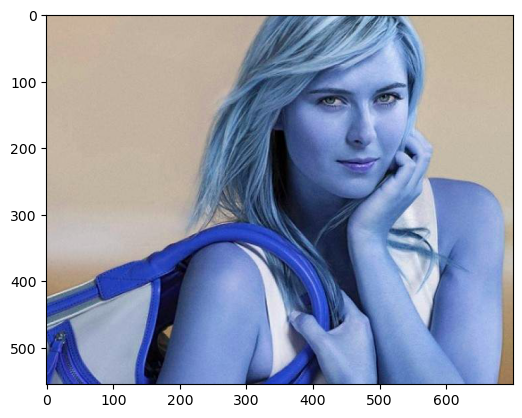

In [ ]:
plt.imshow(img);

In [ ]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray.shape



(555, 700)

In [ ]:
gray

array([[175, 175, 175, ..., 176, 175, 174],
       [175, 175, 175, ..., 177, 175, 174],
       [175, 175, 175, ..., 177, 176, 174],
       ...,
       [ 84,  87,  88, ..., 113, 113, 113],
       [ 88,  89,  90, ..., 113, 113, 113],
       [ 93,  91,  91, ..., 112, 112, 112]], dtype=uint8)

# Preprocessing: Crop the facial region of the image

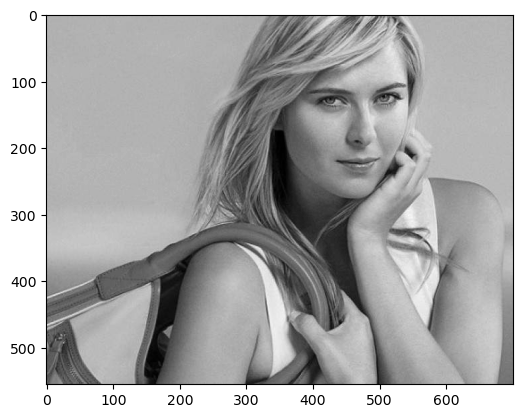

In [ ]:
plt.imshow(gray, cmap='gray');

In [ ]:
face_cascade = cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_eye.xml')

faces = face_cascade.detectMultiScale(gray, 1.3, 5)
faces

array([[352,  38, 233, 233]])

In [ ]:
(x,y,w,h) = faces[0]
x,y,w,h

(352, 38, 233, 233)

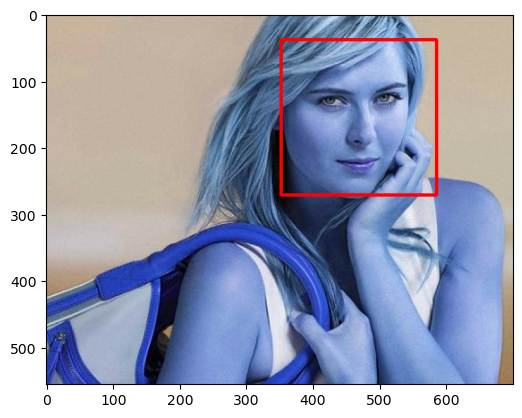

In [ ]:
face_img = cv2.rectangle(img,(x,y),(x+w,y+h),(500,0,0),4)
plt.imshow(face_img);

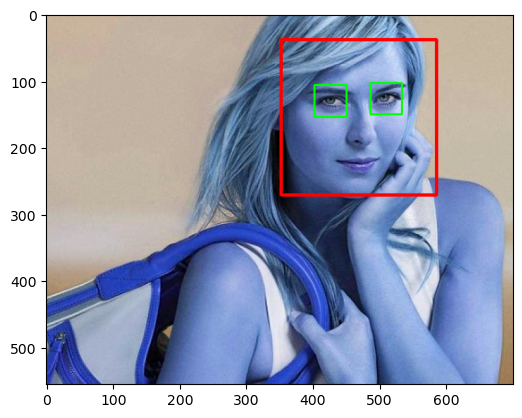

In [ ]:
cv2.destroyAllWindows()
for (x,y,w,h) in faces:
    face_img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = face_img[y:y+h, x:x+w]
    eyes = eye_cascade.detectMultiScale(roi_gray)
    for (ex,ey,ew,eh) in eyes:
        cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)


plt.figure()
plt.imshow(face_img, cmap='gray')
plt.show()

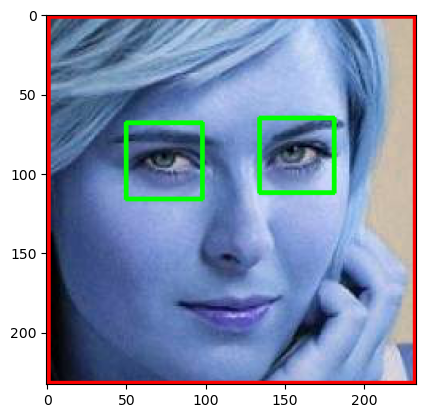

In [ ]:
plt.imshow(roi_color, cmap='gray');

# Preprocessing: Load image, detect face. If eyes >=2, then save and crop the face region

In [ ]:
def get_cropped_image_if_2_eyes(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    for (x,y,w,h) in faces:
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_gray)
        if len(eyes) >= 2:
            return roi_color

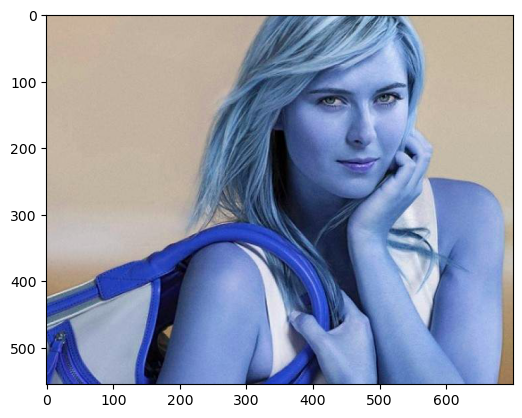

In [ ]:
original_image = cv2.imread('./test_images/sharapova1.jpg')
plt.imshow(original_image);

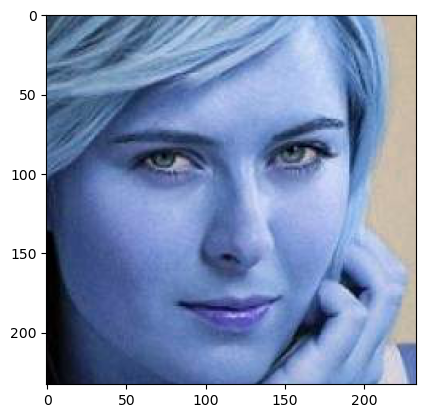

In [ ]:
cropped_image = get_cropped_image_if_2_eyes('./test_images/sharapova1.jpg')
plt.imshow(cropped_image);

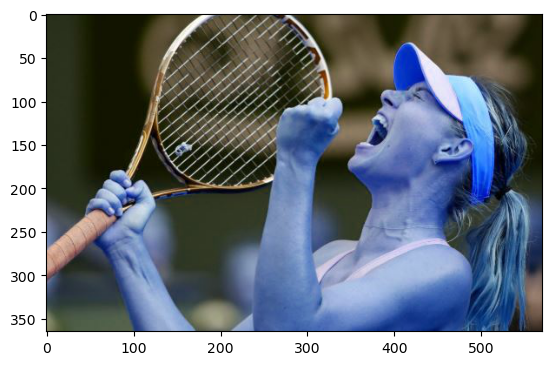

In [ ]:
org_image_obstructed = cv2.imread('./test_images/sharapova2.jpg')
plt.imshow(org_image_obstructed);

In [ ]:
cropped_image_no_2_eyes = get_cropped_image_if_2_eyes('./test_images/sharapova2.jpg')
cropped_image_no_2_eyes

In [ ]:
path_to_data = "./dataset/"
path_to_cr_data = "./dataset/cropped/"

In [ ]:
import os
img_dirs = []
for entry in os.scandir(path_to_data):
    if entry.is_dir():
        img_dirs.append(entry.path)

In [ ]:
img_dirs

['./dataset/cropped',
 './dataset/maria_sharapova',
 './dataset/roger_federer',
 './dataset/serena_williams',
 './dataset/virat_kohli']

In [ ]:
import shutil
if os.path.exists(path_to_cr_data):
     shutil.rmtree(path_to_cr_data)
os.mkdir(path_to_cr_data)

In [ ]:
cropped_image_dirs = []
celebrity_file_names_dict = {}

for img_dir in img_dirs:
    count = 1
    celebrity_name = img_dir.split('/')[-1]
    print(celebrity_name)

    celebrity_file_names_dict[celebrity_name] = []

    for entry in os.scandir(img_dir):
        roi_color = get_cropped_image_if_2_eyes(entry.path)
        if roi_color is not None:
            cropped_folder = path_to_cr_data + celebrity_name
            if not os.path.exists(cropped_folder):
                os.makedirs(cropped_folder)
                cropped_image_dirs.append(cropped_folder)
                print("Generating cropped images in folder: ",cropped_folder)

            cropped_file_name = celebrity_name + str(count) + ".png"
            cropped_file_path = cropped_folder + "/" + cropped_file_name

            cv2.imwrite(cropped_file_path, roi_color)
            celebrity_file_names_dict[celebrity_name].append(cropped_file_path)
            count += 1

cropped
maria_sharapova
Generating cropped images in folder:  ./dataset/cropped/maria_sharapova
roger_federer
Generating cropped images in folder:  ./dataset/cropped/roger_federer
serena_williams
Generating cropped images in folder:  ./dataset/cropped/serena_williams
virat_kohli
Generating cropped images in folder:  ./dataset/cropped/virat_kohli


# Preprocessing: Use wavelet transform as a feature for traning our model

In [ ]:
import pywt

In [ ]:
def w2d(img, mode='haar', level=1):
    imArray = img

    imArray = cv2.cvtColor( imArray,cv2.COLOR_RGB2GRAY )

    imArray =  np.float32(imArray)
    imArray /= 255;

    coeffs=pywt.wavedec2(imArray, mode, level=level)

    coeffs_H=list(coeffs)
    coeffs_H[0] *= 0;

    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)

    return imArray_H

In [ ]:
cropped_img = np.array(roi_color)
cropped_img.shape

(129, 129, 3)

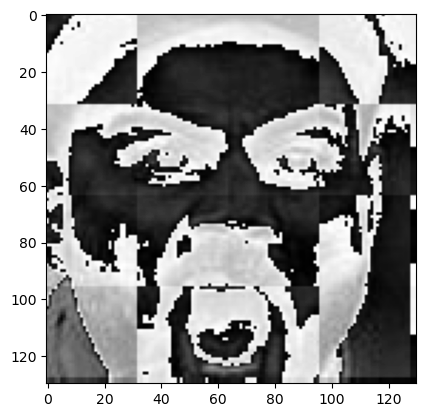

In [ ]:
im_har = w2d(cropped_img,'db1',5)
plt.imshow(im_har, cmap='gray')

In [ ]:
celebrity_file_names_dict = {}
for img_dir in cropped_image_dirs:
    celebrity_name = img_dir.split('/')[-1]
    file_list = []
    for entry in os.scandir(img_dir):
        file_list.append(entry.path)
    celebrity_file_names_dict[celebrity_name] = file_list
celebrity_file_names_dict

{'maria_sharapova': ['./dataset/cropped/maria_sharapova\\maria_sharapova1.png',
  './dataset/cropped/maria_sharapova\\maria_sharapova10.png',
  './dataset/cropped/maria_sharapova\\maria_sharapova11.png',
  './dataset/cropped/maria_sharapova\\maria_sharapova12.png',
  './dataset/cropped/maria_sharapova\\maria_sharapova14.png',
  './dataset/cropped/maria_sharapova\\maria_sharapova16.png',
  './dataset/cropped/maria_sharapova\\maria_sharapova17.png',
  './dataset/cropped/maria_sharapova\\maria_sharapova18.png',
  './dataset/cropped/maria_sharapova\\maria_sharapova19.png',
  './dataset/cropped/maria_sharapova\\maria_sharapova2.png',
  './dataset/cropped/maria_sharapova\\maria_sharapova20.png',
  './dataset/cropped/maria_sharapova\\maria_sharapova21.png',
  './dataset/cropped/maria_sharapova\\maria_sharapova23.png',
  './dataset/cropped/maria_sharapova\\maria_sharapova24.png',
  './dataset/cropped/maria_sharapova\\maria_sharapova25.png',
  './dataset/cropped/maria_sharapova\\maria_sharapova

##### Now I manually examine cropped folder and delete any unwanted images

In [ ]:
class_dict = {}
count = 0
for celebrity_name in celebrity_file_names_dict.keys():
    class_dict[celebrity_name] = count
    count = count + 1
class_dict

{'maria_sharapova': 0,
 'roger_federer': 1,
 'serena_williams': 2,
 'virat_kohli': 3}

In [ ]:
x, y = [], []
for celebrity_name, training_files in celebrity_file_names_dict.items():
    for training_image in training_files:
        img = cv2.imread(training_image)
        scalled_raw_img = cv2.resize(img, (32, 32))
        img_har = w2d(img,'db1',5)
        scalled_img_har = cv2.resize(img_har, (32, 32))
        combined_img = np.vstack((scalled_raw_img.reshape(32*32*3,1),scalled_img_har.reshape(32*32,1)))
        x.append(combined_img)
        y.append(class_dict[celebrity_name])

In [ ]:
len(x[0])

4096

In [ ]:
32*32*3 + 32*32

4096

In [ ]:
x[0]

array([[239],
       [252],
       [250],
       ...,
       [ 49],
       [246],
       [  8]], dtype=uint8)

In [ ]:
y[0]

0

In [ ]:
len(x)

126

In [ ]:
x = np.array(x).reshape(len(x),4096).astype(float)
x.shape

(126, 4096)

In [ ]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=0)

pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel = 'rbf', C = 10))])
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.71875

In [ ]:
print(classification_report(y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       0.89      0.73      0.80        11
           1       0.57      0.57      0.57         7
           2       0.33      0.40      0.36         5
           3       0.90      1.00      0.95         9

    accuracy                           0.72        32
   macro avg       0.67      0.67      0.67        32
weighted avg       0.74      0.72      0.72        32



# Training our model

In [ ]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto',probability=True),
        'params' : {
            'svc__C': [1,10,100,1000],
            'svc__kernel': ['rbf','linear']
        }
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators': [1,5,10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'logisticregression__C': [1,5,10]
        }
    }
}

In [ ]:
scores = []
best_estimators = {}
import pandas as pd
for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf =  GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_

df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df


,model,best_score,best_params
0,svm,0.818713,"{'svc__C': 1, 'svc__kernel': 'linear'}"
1,random_forest,0.818713,{'randomforestclassifier__n_estimators': 10}
2,logistic_regression,0.840351,{'logisticregression__C': 1}


In [ ]:
best_estimators

{'svm': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('svc',
                  SVC(C=1, gamma='auto', kernel='linear', probability=True))]),
 'random_forest': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('randomforestclassifier',
                  RandomForestClassifier(n_estimators=10))]),
 'logistic_regression': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('logisticregression',
                  LogisticRegression(C=1, solver='liblinear'))])}

In [ ]:
best_estimators['svm'].score(X_test,y_test)

0.71875

In [ ]:
best_estimators['random_forest'].score(X_test,y_test)

0.71875

In [ ]:
best_estimators['logistic_regression'].score(X_test,y_test)

0.8125

In [ ]:
best_clf = best_estimators['svm']

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, best_clf.predict(X_test))
cm

array([[9, 1, 1, 0],
       [3, 2, 2, 0],
       [0, 1, 4, 0],
       [1, 0, 0, 8]], dtype=int64)

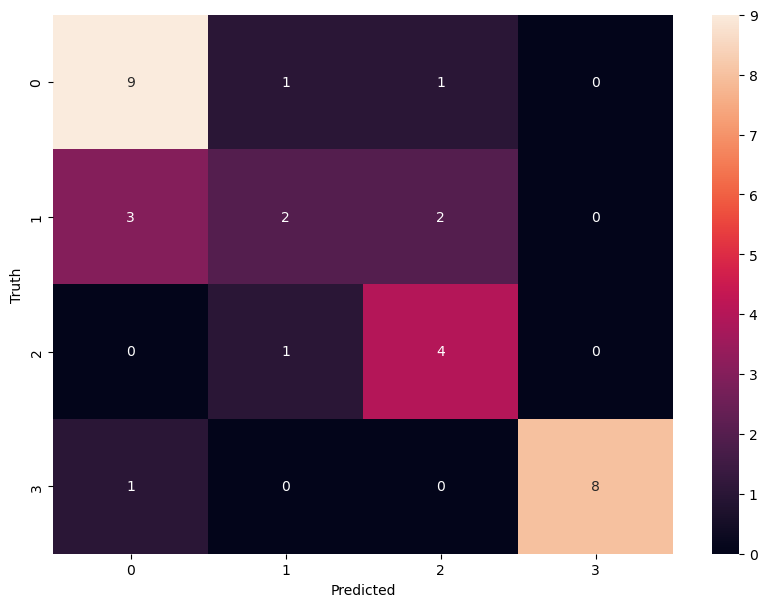

In [ ]:
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth');

In [ ]:
class_dict

{'maria_sharapova': 0,
 'roger_federer': 1,
 'serena_williams': 2,
 'virat_kohli': 3}

In [ ]:
!pip install joblib
import joblib

joblib.dump(best_clf, 'saved_model.pkl')

['saved_model.pkl']

In [ ]:
import json
with open("class_dictionary.json","w") as f:
    f.write(json.dumps(class_dict))

# THE END